In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [125]:
import os

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from agnfinder.prospector import main, load_photometry

from sklearn.covariance import GraphicalLasso, GraphicalLassoCV, MinCovDet, EmpiricalCovariance


In [3]:
DATA_ROOT='/media/mike/internal/agnfinder'

In [4]:
parquet_loc = os.path.join(DATA_ROOT, 'cpz_paper_sample_week3.parquet')

In [5]:
# len(df)

In [6]:
# df = pd.read_parquet(parquet_loc, columns=metadata_cols + unified_cols)
df = pd.read_parquet(parquet_loc)
df = df[~pd.isnull(df['redshift'])].query('redshift > 1e-2').query('redshift < 4').reset_index()

In [7]:
def load_maggies_fast(galaxy):
    # minimal replacement for load_photometry_from_galaxy()
    all_filters = load_photometry.get_filters()
    valid_filters = [f for f in all_filters if load_photometry.filter_has_valid_data(f, galaxy)]
    mags = np.array(galaxy[[f.mag_col for f in valid_filters]].values).astype(float)
    maggies = 10**(-0.4*mags)
    return valid_filters,  maggies

In [8]:
def load_valid_photometry_to_series(galaxy):
    filters, maggies = load_maggies_fast(galaxy)
    photometry = dict(zip([f.bandpass_file for f in filters], maggies))
#     photometry_err = dict(zip([f.name + '_err' for f in filters], maggies_unc))
    data = {}
    data.update(photometry)
#     data.update(photometry_err)
    return pd.Series(data)

In [9]:
rows = []
for i in range(len(df)):
    rows.append(load_valid_photometry_to_series(df.iloc[i]))
phot_df = pd.DataFrame(rows)

In [10]:
phot_df.head(5)

,NUV_galex,FUV_galex,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Ks,...,VISTA_Z,wise_w1,wise_w2,i_kids,r_kids,g_cfhtl,i_cfhtl,r_cfhtl,u_cfhtl,z_cfhtl
0,8.887684e-09,5.445691e-09,1.781900e-08,5.375302e-08,7.967488e-08,1.087319e-07,1.267261e-07,1.256065e-07,1.143024e-07,1.108993e-07,...,1.088652e-07,7.048906e-08,4.474119e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.003750e-09,3.815767e-09,1.186709e-08,6.032281e-08,1.438846e-07,2.069894e-07,2.770264e-07,2.650874e-07,1.942970e-07,2.946234e-07,...,1.772930e-07,1.384870e-07,9.865526e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2.057348e-09,1.378700e-08,6.025764e-08,1.033550e-07,1.505270e-07,2.266809e-07,1.714673e-07,2.697247e-07,...,1.221603e-07,1.684658e-07,1.171390e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.118087e-08,7.962995e-09,2.150587e-08,6.545114e-08,1.140264e-07,1.509821e-07,1.807405e-07,1.783612e-07,1.612472e-07,1.766664e-07,...,1.414613e-07,8.513329e-08,6.275597e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.832349e-09,2.694458e-08,9.828532e-08,1.522470e-07,2.075978e-07,3.307775e-07,2.522924e-07,3.963731e-07,...,1.741281e-07,1.848639e-07,1.374127e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Exclude galex and kids as often wrong/missing
# keep_cols = {col for col in phot_df.columns.values}
reliable_df = phot_df[[col for col in phot_df.columns.values if 'kids' not in col]]
reliable_df = reliable_df[[col for col in phot_df.columns.values if 'galex' not in col]]
reliable_df = reliable_df[[col for col in phot_df.columns.values if 'cfht' not in col]]

In [23]:
reliable_df.head(5)

,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Ks,VISTA_Y,VISTA_Z,wise_w1,wise_w2
0,1.781900e-08,5.375302e-08,7.967488e-08,1.087319e-07,1.267261e-07,1.256065e-07,1.143024e-07,1.108993e-07,1.171704e-07,1.088652e-07,7.048906e-08,4.474119e-08
1,1.186709e-08,6.032281e-08,1.438846e-07,2.069894e-07,2.770264e-07,2.650874e-07,1.942970e-07,2.946234e-07,2.087550e-07,1.772930e-07,1.384870e-07,9.865526e-08
2,2.057348e-09,1.378700e-08,6.025764e-08,1.033550e-07,1.505270e-07,2.266809e-07,1.714673e-07,2.697247e-07,1.424872e-07,1.221603e-07,1.684658e-07,1.171390e-07
3,2.150587e-08,6.545114e-08,1.140264e-07,1.509821e-07,1.807405e-07,1.783612e-07,1.612472e-07,1.766664e-07,1.641209e-07,1.414613e-07,8.513329e-08,6.275597e-08
4,4.832349e-09,2.694458e-08,9.828532e-08,1.522470e-07,2.075978e-07,3.307775e-07,2.522924e-07,3.963731e-07,2.088120e-07,1.741281e-07,1.848639e-07,1.374127e-07


In [13]:
# X = np.random.rand(18,28)
# X[12, 12] = 100
# cov = MinCovDet().fit(X)
# cov.covariance_.shape

In [14]:
# np.around(cov.covariance_, decimals=2)

In [48]:

from sklearn.preprocessing import normalize

In [76]:
X = reliable_df.dropna().values
X.shape
assert not np.isnan(X).any()

In [133]:
cov = GraphicalLassoCV(max_iter=1000, cv=5).fit(X)
# cov = EmpiricalCovariance().fit(X)
# np.around(cov.covariance_, decimals=3)

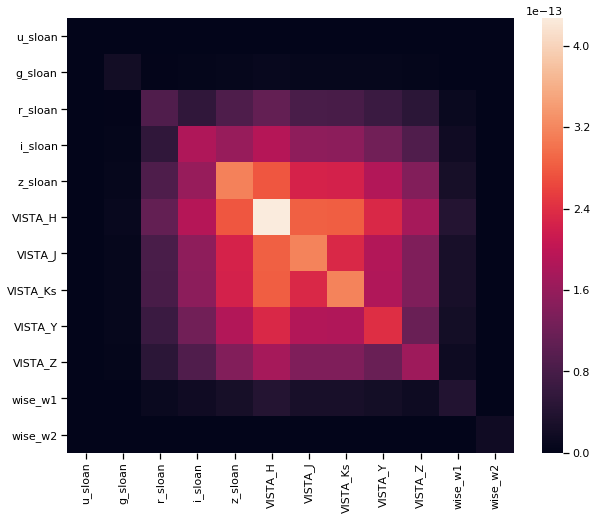

In [134]:
labelled_cov = pd.DataFrame(cov.covariance_, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_cov, ax=ax)

In [135]:
log_X = np.log10(X)
# X = normalize(np.log10(X))

In [136]:
log_cov = GraphicalLassoCV(max_iter=10000, cv=5).fit(log_X)

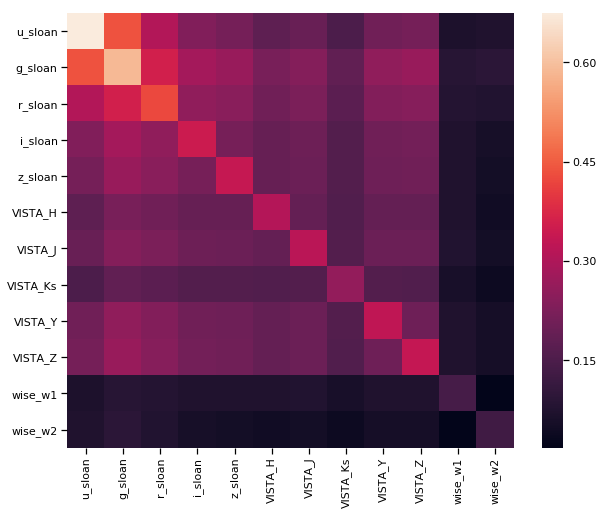

In [137]:
labelled_log_cov = pd.DataFrame(log_cov.covariance_, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_log_cov, ax=ax)

In [138]:
inv_log_cov = np.linalg.inv(log_cov.covariance_)

In [139]:
np.around(inv_log_cov, decimals=3)

array([[ 2.932e+00, -1.826e+00, -5.520e-01, -4.000e-02, -0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -0.000e+00, -0.000e+00],
       [-1.826e+00,  5.259e+00, -1.503e+00, -8.700e-01, -5.370e-01,
        -0.000e+00, -8.700e-02, -0.000e+00, -4.030e-01, -6.500e-01,
         0.000e+00, -7.770e-01],
       [-5.520e-01, -1.503e+00,  6.766e+00, -1.075e+00, -9.200e-01,
        -3.860e-01, -6.150e-01, -1.890e-01, -7.240e-01, -8.220e-01,
        -1.860e-01, -5.380e-01],
       [-4.000e-02, -8.700e-01, -1.075e+00,  6.994e+00, -9.870e-01,
        -6.550e-01, -7.380e-01, -4.790e-01, -7.640e-01, -7.680e-01,
        -1.870e-01, -5.100e-02],
       [-0.000e+00, -5.370e-01, -9.200e-01, -9.870e-01,  6.943e+00,
        -7.930e-01, -8.140e-01, -6.770e-01, -7.940e-01, -7.600e-01,
        -3.100e-01, -7.000e-03],
       [ 0.000e+00, -0.000e+00, -3.860e-01, -6.550e-01, -7.930e-01,
         6.828e+00, -1.060e+00, -1.127e+00, -9.170e-01, -7.870e-01,
        -6.390e-01,

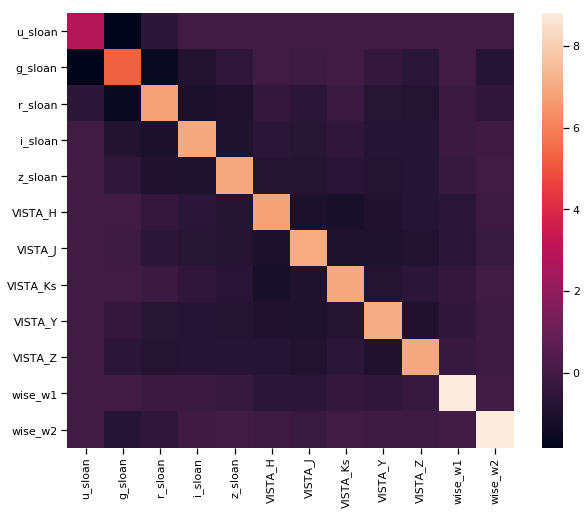

In [140]:
labelled_log_cov = pd.DataFrame(inv_log_cov, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_log_cov, ax=ax)

In [141]:
from scipy.stats import multivariate_normal

In [142]:
log_norm = multivariate_normal(mean=None, cov=log_cov.covariance_)
norm = multivariate_normal(mean=None, cov=cov.covariance_)

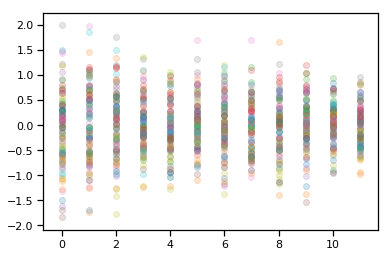

In [108]:
fig, ax = plt.subplots()
for i in range(100):
    ax.scatter(range(12), norm.rvs(), alpha=0.2)

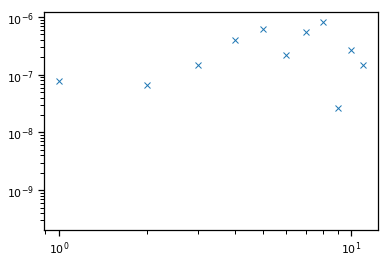

In [167]:
plt.loglog(range(12), np.abs(norm.rvs()), 'x')
# plt.ylim([-2., 2.])

In [153]:
np.log10(np.abs(norm.rvs()))

array([-7.58618321, -6.95732696, -6.9129867 , -6.3789125 , -6.36119193,
       -7.34479442, -6.37939683, -6.08731859, -7.0295505 , -6.74129098,
       -7.31279961, -7.27102741])

(-2.0, 2.0)

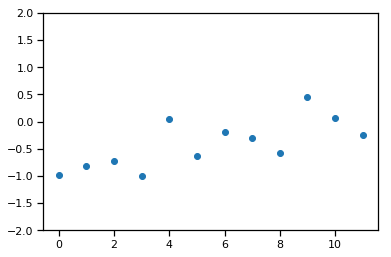

In [149]:
plt.scatter(range(12), log_norm.rvs())
plt.ylim([-2., 2.])